In [27]:
# First going to work out some ideas in a jupyter notebook - Later I will clean this
# up and and create some proper code.

from typing import Iterator, NamedTuple

# Getting some tensorflow warnings, but don't care about those right now
#import warnings
#warnings.filterwarnings('ignore')

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import pathlib
import string
import glob2
import xml.etree.ElementTree as ET
import time

import keras

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp

import matplotlib.pyplot as plt

import dataclasses

tf.config.experimental.set_visible_devices([], "GPU")

In [28]:
# The IAM On-Line Handwriting Database (IAM-OnDB) is required for this project, so you will need to ask for
# permission for that and download. https://fki.tic.heia-fr.ch/databases/iam-on-line-handwriting-database 
# Here we will create a wrapper class to give us some tensorflow dataset summaries of just the writing portion.

class WritingGenerator():
    def __init__(self, f_name, batch_size=32):   
        self.all_x = []
        self.all_y = []

        # How we might pad each stroke to a consistent length and batch it for fitting - With the amount 
        # of data in the database and the complexity of a Transformer, this should probably be kept to
        # under 400 strokes and 20 characters. There is an issue here though that different people use 
        # different amounts of strokes/char and this can confuse the network. I am not sure there is an
        # elegant way to handle that problem with a Transformer network, as we would need about 1500
        # tokens to read in every writing sample fully with padding and this is beyond a standard 
        # Transformer. Perhaps a PerceiverAR is next?
        self.MAX_STROKE_LEN = 400
        self.MAX_CHAR_SEQ_LEN = 30         
        
        self.f_name = f_name
        
        self.batch_size = batch_size
        
        self.padding_value = -1.
        self.char_padding_value = 0.

        # You will need to change this and point to your own database where you unzipped all of the 
        # IAM-OnDB strokes and corresponding ascii
        base_dir_strokes='../IamONDB/lineStrokes'
        base_dir_ascii='../IamONDB/ascii'
        
        try:
            f = open(f_name, 'r')
        except IOError:
            print("Error opening file")
            return 0
      
        f_train = list(f)
        f.close()
        
        self.n_samp = len(f_train)

        print('Reading ' + str(self.n_samp) + ' files')

        # This will contain a list of all stroke files
        self.f_sub_list_strokes = []
        # This will contain a list of corresponding ascii line files
        self.f_sub_list_ascii = []

        # First create a list of all subfiles in the .txt list - we are going to treat each line as a separate sample here
        for i, fname in enumerate(f_train):
            path_stroke = glob2.glob(base_dir_strokes + '/' + fname.strip()[0:3] + '/' + fname.strip()[0:7] + '/' + fname.strip() + '-*.xml')    
              
            self.f_sub_list_strokes += path_stroke

            path_line = glob2.glob(base_dir_ascii + '/' + fname.strip()[0:3] + '/' + fname.strip()[0:7] + '/' + fname.strip() + '.txt')   
            # We want a 1 to 1 matching of strokes to ascii.  We will pull out the appropriate line when we create the dataset
            self.f_sub_list_ascii += path_line * len(path_stroke)
                        
        # list datasets
        self.list_ds_strokes = tf.data.Dataset.from_tensor_slices(self.f_sub_list_strokes)
        self.list_ds_ascii = tf.data.Dataset.from_tensor_slices(self.f_sub_list_ascii)

        # Text helper functions and variables.  All lines of text need to be one-hot-encoded for proper integration into the attention
        # mechanism of the model
        self.vocab = string.printable

        # I am adding 1 to all character enumerations so that 0 is reserved for padding only and can be ignored in the model
        self.char2idx = {u: i+1 for i, u in enumerate(self.vocab)}
        self.idx2char = {i+1: u for i, u in enumerate(self.vocab)}

        self.invert_one_hot = lambda x: tf.argmax(x, -1).numpy()

        self.text_to_int = lambda x: np.array([self.char2idx[c] for c in x])
        self.int_to_text = lambda x: ''.join(np.array([self.idx2char[i] for i in x]))

        # Combine
        self.list_ds = tf.data.Dataset.zip((self.list_ds_strokes, self.list_ds_ascii))
        
        # Create a datbase of tuples (strokes, matching ascii)
        self.labeled_ds = self.list_ds.map(lambda x, y: tf.py_function(self.process_stroke, (x, y), (tf.float32, tf.float32)))
        
        self.cached_example_dataset = self.labeled_ds.shuffle(buffer_size=1024).cache().take(1024)
        
    # Create a dataset of strokes and matching lines - As mentioned before, each line is a training sample in this version
    def process_stroke(self, file_path_stroke, file_path_lines):
        line_num = int(file_path_stroke.numpy()[-6:-4])
        strokes = self.get_strokes(file_path_stroke.numpy())
        # Not sure the best way to combine two files
        lines = self.get_ascii(file_path_lines)

        U = lines[line_num-1]
        U = U[:self.MAX_CHAR_SEQ_LEN]
        U_conv = tf.keras.backend.one_hot(self.text_to_int(U), len(self.vocab)+1)

        return strokes, U_conv

    # Returns only the strokes of the dataset as a tuple with a label of the same data 1 timestamp ahead
    @property
    def batched_set(self):
        # We don't care about the line data for this version, so remove that first

        stroke_only_ds=self.labeled_ds.map(lambda x, y: x)
        
        # All sequences will be strictly right padded so that tensorflow will run them on a GPU
        batched_dataset = stroke_only_ds.padded_batch(self.batch_size, padded_shapes=([self.MAX_STROKE_LEN, 3]), 
                                                      drop_remainder=True, padding_values=self.padding_value)

        return batched_dataset.map(self.dense_1_step).cache()
        return batched_dataset.cache()

    # Returns only the strokes of the dataset as a tuple with a label of the same data 1 timestamp ahead
    # This one also returns the character sequence U being written as a one-hot-encoded tensor
    @property
    def batched_onehot_set(self):
        batched_dataset_one_hot = self.labeled_ds.padded_batch(
            self.batch_size, padded_shapes=([self.MAX_STROKE_LEN, 3], 
                                            [self.MAX_CHAR_SEQ_LEN, len(self.vocab)+1]), 
                                            drop_remainder=False, padding_values=(self.padding_value, self.char_padding_value))        

        return batched_dataset_one_hot.map(self.dense_1_step)

    # We will make our prediction 1 step ahead
    def dense_1_step(self, batch_stroke, batch_char_seq):
        # Shift features and labels one step relative to each other.
        return (batch_stroke[:, :, :], batch_char_seq ), batch_stroke[:, :, :]
    
    def get_examples(self, num_examples):
        example_dataset = self.labeled_ds.shuffle(100).take(num_examples)
        
        #example_dataset = self.labeled_ds.batch(1).shuffle(100).take(num_examples)
        
        return example_dataset
        
    def get_strokes(self, fname):
        root = ET.parse(fname).getroot()

        # Parse one xml file
        strokeset = root.find('StrokeSet')

        x_samp = []

        for stroke in strokeset.iter('Stroke'):
            for child in stroke:
                x_samp.append([float(child.attrib.get('x')), -1*float(child.attrib.get('y')), 0.])

            # As in Graves, 2013, we add a binary vector indicating the end of a stroke
            x_samp[-1][-1]=1.0

        x_samp = np.asarray(x_samp)
        x_samp = x_samp[:self.MAX_STROKE_LEN, :]

        # We want the data as offsets though, not raw strokes - easier to train a network to predict small changes in the next timestamp
        x_off = np.hstack(([x_samp[1:, :2]-x_samp[:-1, :2], x_samp[1:, 2:3]]))
        x_off = np.vstack(([0, 0, 0], x_off))

        x_off[:, 0] -= 6.43
        x_off[:, 1] -= -0.28

        #x_off[:, 0] /= np.std(x_off[:, 0])
        #x_off[:, 1] /= np.std(x_off[:, 1])

        x_off[:, 0] /= 37.74
        x_off[:, 1] /= 32.96

        return x_off
 
    # Read an ascii file form the iamONDB and return all of the lines as strings
    def get_ascii(self, fname):
        text_file = open(fname.numpy(), "r")
        lines = text_file.read()
        lines = lines.split('CSR:')

        return lines[1].strip().split('\n')       
    
    def __repr__(self):
        return '\n'.join([
            f'Writing Dataset for: {self.f_name}'
        ])

In [29]:
# Drawing function for strokes
# TODO: This should be in the writing class

def plot_stroke(offsets, lines):
    plt.figure(num=None, figsize=(15, 4))

    strokes=np.array([np.cumsum(offsets[:,0]*37.74+6.43), np.cumsum(offsets[:,1]*32.96-0.28), offsets[:,2]]);    
    stroke=[]

    strokes[-1, -1] = -1

    for x, y, eos in strokes.T:
        stroke.append([x, y])
        if eos > 0.1:
            stroke=np.asarray(stroke);
            #print(stroke.shape)
            plt.plot(stroke[:,0], stroke[:,1], 'k')
            stroke = []

    clean_txt = lines

    clean_txt = np.delete(clean_txt, np.argmax(clean_txt, -1) == 0.0, axis=0)

    # TODO: This should be passed in
    plt.title(train.int_to_text(train.invert_one_hot(clean_txt)))

    plt.show()

In [30]:
# I concatenated all data into one set as we just want the maximum amount of data to train the 
# network to write and 
# don't really care about evaluation or test sets for this project
train = WritingGenerator('../IamONDB/trainset_d.txt')
val = WritingGenerator('../IamONDB/testset_v.txt')

Reading 1726 files
Reading 192 files


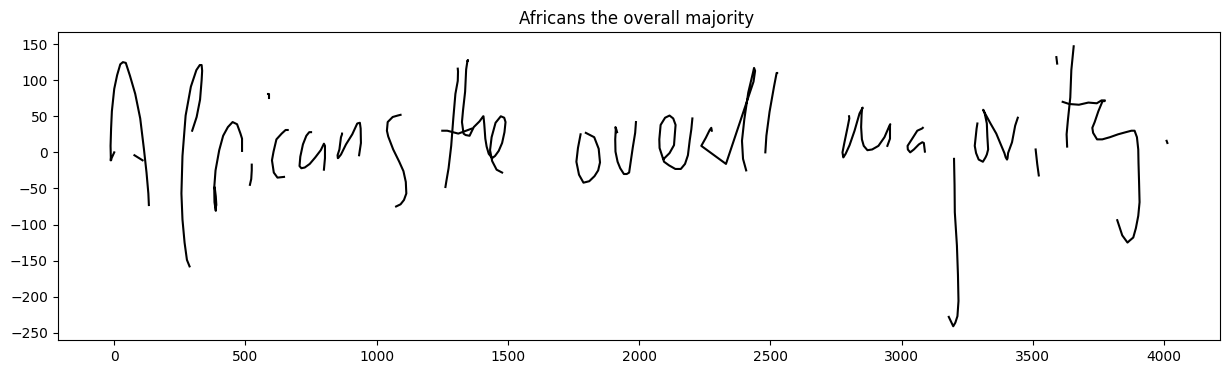

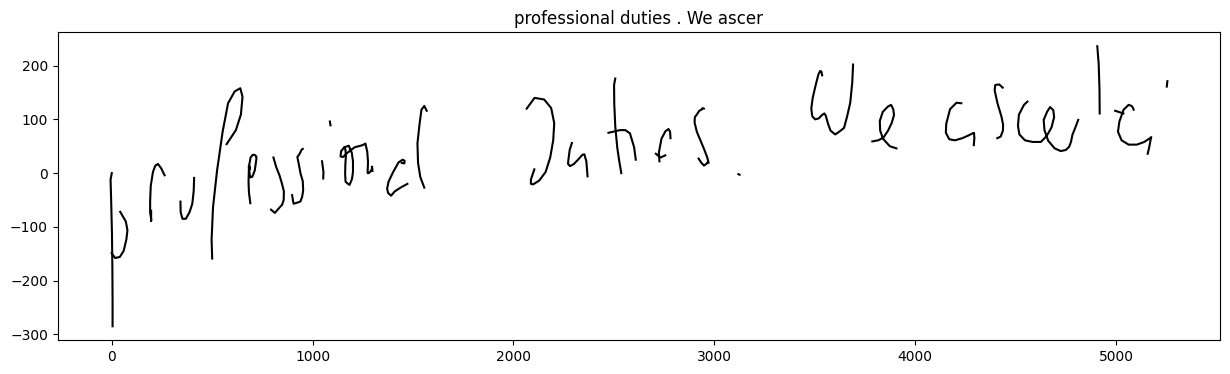

In [116]:
# Inspect our dataset.  It returns a tuple of stroke offsets and matching ascii strings
# You can see that there isn't an exact match for every subject for strokes to ascii 
# because of the token limit in Transformers
SUB = 2

for s, l in train.batched_onehot_set.take(2).cache():
    plot_stroke(s[0][SUB, :, :], s[1][SUB, :])

In [ ]:
# Much of the following code is from the excellent Tensorflow tutorial on Transformers: https://www.tensorflow.org/text/tutorials/transformer

# STEP 1 - Positional Embeddings from the original paper. Although, you can also just add a randomized vector and I may try that next
# TODO: Switch to a random vector and see if performance suffers vs this complex embedding.

def get_angles(pos, i, d_model):
  angle_rates = 1. / jnp.power(10000, (2 * (i//2)) / jnp.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(jnp.arange(position)[:, jnp.newaxis],
                          jnp.arange(d_model)[jnp.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads = angle_rads.at[:, 0::2].set(jnp.sin(angle_rads[:, 0::2]))

  # apply cos to odd indices in the array; 2i+1
  angle_rads = angle_rads.at[:, 1::2].set(jnp.cos(angle_rads[:, 1::2]))

  pos_encoding = angle_rads[jnp.newaxis, ...]

  return pos_encoding

In [ ]:
# From the perceiver-ar codebase: https://github.com/google-research/perceiver-ar
def generate_sinusoidal_features(size,
                                 max_len=2048,
                                 min_scale=1.0,
                                 max_scale=10000.0):
  """1D Sinusoidal Position Embedding Initializer.

  Args:
    size: embedding size.
    max_len: maximum possible length for the input.
    min_scale: float: minimum frequency-scale in sine grating.
    max_scale: float: maximum frequency-scale in sine grating.

  Returns:
    output: init function returning `(max_len, size)`
  """

  pe = np.zeros((max_len, size), dtype=np.float32)
  position = np.arange(0, max_len)[:, np.newaxis]
  scale_factor = -np.log(max_scale / min_scale) / (size // 2 - 1)
  div_term = min_scale * np.exp(np.arange(0, size // 2) * scale_factor)
  pe[:, :size // 2] = np.sin(position * div_term)
  pe[:, size // 2: 2 * (size // 2)] = np.cos(position * div_term)
  return jnp.array(pe)

In [ ]:
# Build up some pieces in haiku. See: https://github.com/deepmind/dm-haiku/tree/main/examples/transformer

def layer_norm(x: jnp.ndarray) -> jnp.ndarray:
  """Applies a unique LayerNorm to x with default settings."""
  ln = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
  return ln(x)

def point_wise_feed_forward(x: jnp.ndarray, d_model: int, dff: int) -> jnp.ndarray:
  mlp = hk.Sequential([
      hk.Linear(dff, name='Lin1'), lambda x: jax.nn.relu(x)**2, # (batch_size, seq_len, dff)
      hk.Linear(d_model, name='Lin2')          # (batch_size, seq_len, d_model)
  ])
  return mlp(x)

In [ ]:
# Test out the point_wise_feed_forward network
network = hk.transform(point_wise_feed_forward)
params = network.init(rng=jax.random.PRNGKey(42), x=jnp.zeros((32, 100)), d_model=128, dff=128)

/home/don/ML-tests/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/don/ML-tests/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


In [ ]:
import types
from typing import Optional

class MultiHeadAttention_G(hk.Module):
  """Multi-headed attention mechanism.

  As described in the vanilla Transformer paper:
    "Attention is all you need" https://arxiv.org/abs/1706.03762
  """

  def __init__(
      self,
      num_heads: int,
      key_size: int,
      # TODO(romanring, tycai): migrate to a more generic `w_init` initializer.
      w_init_scale: float,
      value_size: Optional[int] = None,
      model_size: Optional[int] = None,
      name: Optional[str] = None,
  ):
    super().__init__(name=name)
    self.num_heads = num_heads
    self.key_size = key_size
    self.value_size = value_size or key_size
    self.model_size = model_size or key_size * num_heads
    self.w_init = hk.initializers.VarianceScaling(w_init_scale)

  def __call__(
      self,
      query: jnp.ndarray,
      key: jnp.ndarray,
      value: jnp.ndarray,
      mask: Optional[jnp.ndarray] = None,
  ) -> jnp.ndarray:
    """Compute (optionally masked) MHA with queries, keys & values."""
    query_heads = self._linear_projection(query, self.key_size, "query")
    key_heads = self._linear_projection(key, self.key_size, "key")
    value_heads = self._linear_projection(value, self.value_size, "value")

    attn_logits = jnp.einsum("...thd,...Thd->...htT", query_heads, key_heads)
    sqrt_key_size = np.sqrt(self.key_size).astype(key.dtype)
    attn_logits = attn_logits / sqrt_key_size
    if mask is not None:
      if mask.ndim != attn_logits.ndim:
        raise ValueError(f"Mask dimensionality {mask.ndim} must match logits "
                         f"{attn_logits.ndim}.")
      attn_logits = jnp.where(mask, attn_logits, -1e30)

    attn_weights = jax.nn.softmax(attn_logits)
    attn = jnp.einsum("...htT,...Thd->...thd", attn_weights, value_heads)
    # Concatenate attention matrix of all heads into a single vector.
    attn_vec = jnp.reshape(attn, (*query.shape[:-1], -1))

    # Don - This is the only line I changed. I just output the attention weights 
    # as a second return so that I can store them and plot them as I go.
    return hk.Linear(self.model_size, w_init=self.w_init)(attn_vec), attn_weights

  @hk.transparent
  def _linear_projection(
      self,
      x: jnp.ndarray,
      head_size: int,
      name: Optional[str] = None
  ) -> jnp.ndarray:
    y = hk.Linear(self.num_heads * head_size, w_init=self.w_init, name=name)(x)
    return y.reshape((*x.shape[:-1], self.num_heads, head_size))

In [ ]:
x=jnp.ones((32, 50, 128))

In [ ]:
# Going to redefine the Multi Head Attention Class to return the attention weights as well so 
# we can plot those to see our model in action.

In [ ]:
# The Encoder - Self attention over the input characters - The only mask needed is padded characters
class Encoder_Layer(hk.Module):
    # The Encoder Layer is one stack of the Encoder, putting the multihead together 
    # with the point wise network and some normalization layers
    def __init__(self, key_size, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__(name='EncoderLayer')

        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        # In haiku the key_size is specified manually instead of d_model/num_heads. Internally, it 
        # will project Q, K, and V to dimensions (*leading_dims, num_heads, head_size) before 
        # computing attention logits. After that you can futher modify it to project to d_model.
        # TODO: Define an initializer here?
        self.mha = MultiHeadAttention_G(num_heads=num_heads, key_size=key_size, model_size=d_model, w_init_scale=1)

    # I don't think haiku has any method for dealing with removing dropout automatically, so we will need
    # to always pass in a training flag to remove it if necessary during inference
    def __call__(
        self,
        x: jnp.ndarray,
        mask,
        training=True
    ) -> jnp.ndarray:
        # Need to format the mask properly across q_vals * k_vals
        mask1 = mask[:, None, :, None] 
        mask2 = mask[:, None, None, :] 
        mask = mask1 & mask2  # [B, H=1, T, T]

        # Using the pre-LN Transformer - See Xiong et. al. 2020
        x_norm = layer_norm(x)

        # Encoder attention weights are not that interesting to look at.
        attn_out, _ = self.mha(x_norm, x_norm, x_norm, mask)
        if training:
            attn_out = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out)

        # residual 1
        attn_out = x + attn_out
        #attn_out1 = layer_norm(attn_out)

        attn_out1 = layer_norm(attn_out)

        ffn_out = point_wise_feed_forward(attn_out1, self.d_model, self.dff)
        if training:
            ffn_out = hk.dropout(hk.next_rng_key(), self.dropout_rate, ffn_out)
        
        # residual 2
        ffn_out = attn_out + ffn_out

        # The mention adding another layer norm before the final output
        #attn_out3 = layer_norm(ffn_out)

        return ffn_out

# The Encoder module handles the pre-processing of the character data - embedding + positional encoding
# and looping over the requested number of encoder attention layers
class Encoder(hk.Module):
    def __init__(self, num_layers, key_size, d_model, num_heads, dff, maximum_positional_encoding, 
        dropout_rate=0.1):
        super().__init__(name='Encoder')

        self.num_layers = num_layers
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.enc_layers = [Encoder_Layer(key_size, d_model, num_heads, dff, dropout_rate) 
                        for _ in range(num_layers)]

        # Postional encodings - enocodings are static in this case and not learned parameters
        # TODO: Compare this to random
        #self.positional_embeddings = positional_encoding(maximum_positional_encoding, d_model)
        self.positional_embeddings = generate_sinusoidal_features(d_model, maximum_positional_encoding)

    def __call__(
        self,
        x: jnp.ndarray,
        mask,
        training=True
    ) -> jnp.ndarray:
        # The mask for the encoder needs to be broadcastable to the last 2 dimensions (1, 1, T, T)
        # because the multihead attention is parallel - See https://www.tensorflow.org/text/tutorials/transformer
        
        seq_len = jnp.shape(x)[1]
        
        # We are using one-hot encoded characters and not embedded words, so we will just use a
        # prenet to connect that to our model of depth d_model instead
        x = hk.Linear(self.d_model, name='prenet')(x)

        x = x + self.positional_embeddings[jnp.newaxis, :seq_len, :]

        if training:
            x = hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

        for i in range(self.num_layers):
             x = self.enc_layers[i](x, mask, training)

        return x

In [ ]:
# Test Encoder - x input will be [B, T, d_model] embedded characters with positional encoding added
x=s[1].numpy()

mask = jnp.not_equal(jnp.sum(x, -1), 0)

def encoder(x: jnp.ndarray, mask: jnp.ndarray) -> jnp.ndarray:
    enc = Encoder(4, 32, 128, 4, 128, 1024)

    out = enc(x, mask)

    return out

network = hk.transform(encoder)
key = jax.random.PRNGKey(42) 
params = network.init(rng=key, x=x, mask=mask)

out = network.apply(params, key, x=x, mask=mask)

out.shape

#params

/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


(32, 30, 128)

In [ ]:
# The Decoder - Very similar to the Encoder with a self-attention mechanism, but there is a second cross-attention mechanism with
# the output of the Encoder as K, V and the outputs of the self-attention mechanism as Q. That is, as the Decoder attemps to draw
# hand written text based on the Encoder characters, it asks what parts of the encoding are important. Hopefully it learns this 
# relationship and we should see that reflected in the attention weights. It uses additional causal-masking to prevent future tokens
# from being attended to as it attempts to predict the next token.

class Decoder_Layer(hk.Module):
    # The Decoder Layer is one stack of the Decoder, putting the 2 multihead attention blocks together 
    # with the point wise network and some normalization layers
    def __init__(self, key_size, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__(name='DecoderLayer')

        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.mha_self = MultiHeadAttention_G(num_heads=num_heads, key_size=key_size, model_size=d_model, w_init_scale=1)
        self.mha_cross = MultiHeadAttention_G(num_heads=num_heads, key_size=key_size, model_size=d_model, w_init_scale=1)

    # Mask here will only deal with the padding mask. We will compute the causal mask as needed in the calling function
    def __call__(
        self,
        x: jnp.ndarray,
        enc_output: jnp.ndarray,
        mask,       # Mask of stroke padding
        enc_mask,   # Mask of character padding
        training=True
    ) -> jnp.ndarray:
        seq_len = jnp.shape(x)[1]

        # Need to format the mask properly across q_vals * k_vals
        mask1 = mask[:, None, :, None] 
        mask2 = mask[:, None, None, :] 
        mask2 = mask1 & mask2  # [B, H=1, T, T]

        # Compute the causal mask and combine with the padding mask for the strokes
        causal_mask = np.tril(np.ones((1, 1, seq_len, seq_len)))  # [B=1, H=1, T, T]
        self_mask = mask2 * causal_mask  # [B, H=1, T, T]

        x_norm = layer_norm(x)

        # Self-attention
        attn_out, attn_w1 = self.mha_self(x_norm, x_norm, x_norm, self_mask)
        if training:
            attn_out = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out)

        # residual 1
        attn_out = x + attn_out
        attn_out1 = layer_norm(attn_out)

        # Cross-attention
        # Combine the 2 padding masks. We don't need to attend to encodings that are padded or 
        # query decodings that are padded

        # Need to format the mask properly across q_vals * k_vals
        # TODO: This code is repeated a lot. This needs to be refactored.
        #mask1 = mask[:, None, :, None] 
        mask1 = jnp.ones(mask1.shape, dtype=bool)
        mask2 = enc_mask[:, None, None, :] 
        cross_mask = mask1 & mask2  # [B, H=1, T, T]

        #print (mask1.shape)

        attn_out2, attn_w2 = self.mha_cross(attn_out1, enc_output, enc_output, cross_mask)
        if training:
            attn_out2 = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out2)

        # residual 2
        attn_out2 = attn_out + attn_out2
        attn_out3 = layer_norm(attn_out2)

        attn_out3 = point_wise_feed_forward(attn_out3, self.d_model, self.dff)
        if training:
            attn_out3 = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out3)
        
        # residual 3
        attn_out3 = attn_out2 + attn_out3
        out_all = layer_norm(attn_out3)

        # TODO: It looks like the haiku transformer does not allow the return of the attent weights,
        # only the final projection. I am going to fork my own repo and add that (maybe pull request as well)
        return out_all, attn_w1, attn_w2

def decoder_prenet(x: jnp.ndarray, d_model: int) -> jnp.ndarray:
  mlp = hk.Sequential([
      #hk.Linear(d_model, name='D_Prenet1'), jax.nn.relu(x),    # (batch_size, seq_len, d_model)
      #hk.Linear(d_model, name='D_Prenet2'), jax.nn.relu(x),   # (batch_size, seq_len, d_model)
      hk.Linear(d_model, name='D_Prenet3')                 # (batch_size, seq_len, d_model)
  ])
  return mlp(x)

# The Decoder module handles the pre-processing of the stroke data - embedding + positional encoding
# and looping over the requested number of decoder attention layers
class Decoder(hk.Module):
    def __init__(self, num_layers, key_size, d_model, num_heads, dff, maximum_positional_encoding, 
        dropout_rate=0.1):
        super().__init__(name='Decoder')

        self.num_layers = num_layers
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.dec_layers = [Decoder_Layer(key_size, d_model, num_heads, dff, dropout_rate) 
                       for _ in range(num_layers)]

        # Postional encodings - enocodings are static in this case and not learned parameters
        # TODO: Compare this to random
        #self.positional_embeddings = positional_encoding(maximum_positional_encoding, d_model)
        self.positional_embeddings = generate_sinusoidal_features(d_model, maximum_positional_encoding)

    def __call__(
        self,
        x: jnp.ndarray,
        enc_output: jnp.ndarray,
        enc_mask,
        training=True
    ) -> jnp.ndarray:
        # The mask for the encoder needs to be broadcastable to the last 2 dimensions (1, 1, T, T)
        # because the multihead attention is parallel - See https://www.tensorflow.org/text/tutorials/transformer
        # We just check the pen up for a negative value to indicate a masked stroke (otherwise is should be 
        # 0 or 1)
        # TODO: padding_value should be passed in or made global
        mask = jnp.not_equal(x[:,:,2], train.padding_value)

        seq_len = jnp.shape(x)[1]
        attention_weights = {}
        
        # Adding a small MLP here to give the network an opportunity to construct filters and non-linear relationships
        # among the raw stroke data
        #x = decoder_prenet(x, self.d_model)
        x = hk.BatchApply(hk.Linear(self.d_model))(x)

        x = x + self.positional_embeddings[jnp.newaxis, :seq_len, :]

        if training:
            x = hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

        for i in range(self.num_layers):
            x, attn1, attn2 = self.dec_layers[i](x, enc_output, mask, enc_mask, training)

            # See the Tensorflow example for MHA - Store the weights in a dictionary with sensible labels
            attention_weights['decoder_layer{}_block1'.format(i+1)] = attn1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = attn2

        # TODO: Modify the mha from haiku to output attention_weights as well
        return x, attention_weights

In [ ]:
# Test Decoder - x input will be [B, T, d_model] embedded characters with positional encoding added
x=s[1].numpy()

mask = jnp.not_equal(jnp.sum(x, -1), 0)

x=jnp.asarray(s[0].numpy())

def decoder(x: jnp.ndarray, enc_output: jnp.ndarray, enc_mask: jnp.ndarray) -> jnp.ndarray:
    dec = Decoder(4, 32, 128, 4, 128, 1200)

    return dec(x, enc_output, mask)

network = hk.transform(decoder)
key = jax.random.PRNGKey(42) 
params = network.init(rng=key, x=jnp.asarray(s[0].numpy()), enc_output=out, enc_mask=mask)

out2, attn_w = network.apply(params, key, x=x, enc_output=out, enc_mask=mask)

# layer x block 2 will be the cross-attention, which is what we are generally intersted in to 
# check for alignment
attn_w['decoder_layer1_block2'].shape

/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/basic.py:195: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  for a in jax.tree_leaves(args):


[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]]


 [[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]]


 [[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]]


 ...


 [[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ Tru

(32, 4, 400, 30)

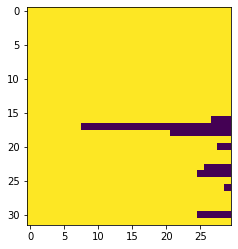

In [ ]:
plt.imshow(mask)

In [ ]:
# The Writing Transformer

# Output space - number of parameters in the mixture model
NUM_MIX_COM = 20
# weights + means (x + y) + std. devs. (x + y) + correlations + end_of_stroke
# Unlike the Mixture Density Network notebook we are going to add cross correlation
# terms to our loss and sampling functions for added complexity of the density 
# estimations
NUM_PARAMS = NUM_MIX_COM + NUM_MIX_COM*2 + NUM_MIX_COM*2 + NUM_MIX_COM + 1

class Writing_Transformer(hk.Module):
    def __init__(self, num_layers, key_size, d_model, num_heads, dff, pe_encoding, pe_target, 
        dropout_rate=0.1):
        super().__init__(name='Writing_Transformer')

        self.num_layers = num_layers
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.enc = Encoder(num_layers, key_size, d_model, num_heads, dff, pe_encoding, dropout_rate)
        self.dec = Decoder(num_layers, key_size, d_model, num_heads, dff, pe_target, dropout_rate)

    def __call__(
        self,
        inp: jnp.ndarray,
        tar: jnp.ndarray,
        training=True
    ) -> jnp.ndarray:
        enc_mask = jnp.not_equal(jnp.sum(inp, -1), 0)

        # The Encoder
        enc_output = self.enc(inp, enc_mask, training)

        # The Decoder
        dec_output, attn_w = self.dec(tar, enc_output, enc_mask, training)

        # The final layer to give us our logits
        final_output = hk.Linear(NUM_PARAMS, name='final_layer')(dec_output)

        return final_output, attn_w

In [ ]:
# Test The full network
def writing_transformer(inp: jnp.ndarray, tar: jnp.ndarray) -> jnp.ndarray:
    tra = Writing_Transformer(4, 32, 128, 4, 128, 200, 1500, 0.0)

    return tra(inp, tar)

network = hk.transform(writing_transformer)
key = jax.random.PRNGKey(42)

rng, init_rng = jax.random.split(key)
params = network.init(rng=key, inp=inp, tar=tar)

out3 = network.apply(params, key, inp=inp, tar=tar)

out3, attn_w

NameError: name 'tar' is not defined

In [43]:
# Now for the loss function
# TODO: I think there are a lot of edge cases here that will result in NaNs when training.

EPS = 0.0000001

LOG2PI = jnp.log(2*jnp.pi)

def l2_loss(x, alpha):
    return alpha * (x ** 2).mean()

#@hk.transform
@jax.jit
def my_loss_fun_MDN(params, rng, batch: tuple) -> jnp.ndarray:
    # Predict the next strokes

    # We split the input and then use 1 sample ahead as the target (y_true)
    inp = batch[0][:, :-1]
    y_true = batch[0][:, 1:]

    logits, _ = network.apply(params, rng, batch[1], inp, True)

    pis, mu, sig, rho, eos = jnp.array_split(logits, [NUM_MIX_COM, NUM_MIX_COM*3, NUM_MIX_COM*5, NUM_MIX_COM*6], axis=-1)
    
    #print(eos.shape)

    # weights - must be a probability distribution so softmax over all components
    pis = jax.nn.softmax(pis)

    # What if we smooth the labels so that the model doesn't become overconfident in one distribution?
    #pis = optax.smooth_labels(pis, 0.25)
    
    # means - no transformation needed
    mu_x1, mu_x2 = jnp.array_split(mu, 2, axis=-1)
    
    # standard deviations - must be strictly positive so exponent
    sig = jnp.exp(sig)

    # More numerically stable without the need for clipping
    #sig = jax.nn.elu(sig) + 1 + EPS
    
    #sig = jnp.clip(sig, EPS, np.inf)
    
    sig_x1, sig_x2 = jnp.array_split(sig, 2, axis=-1)
    
    x1, x2, eos_true = jnp.array_split(y_true, 3, axis=-1)
    
    eos_true = jnp.squeeze(eos_true)
        
    # correlations - squish to -1 to 1 with tanh activation
    rho = jnp.tanh(rho)
    
    #rho = jnp.clip(rho, -1.+EPS, 1.-EPS)
    
    # Define Z as in Graves, 2013
    Z = jnp.square( ( x1-mu_x1 ) / sig_x1 ) + jnp.square( ( x2-mu_x2 ) / sig_x2 ) - ( 2 * rho * (x1-mu_x1) * (x2-mu_x2) ) / ( sig_x1*sig_x2 )
    
    one_minus_rho_square = 1. - jnp.square(rho)
    
    # Now form Gaussian mixtures
    #term1 = jnp.divide(1., ( 2. * np.pi * sig_x1 * sig_x2 * jnp.sqrt( one_minus_rho_square ) ))
    # This exp is causing instability during training
    #term2 = jnp.exp( jnp.divide ( (-1. * Z) , (2.*( one_minus_rho_square )) ))

    term3 = jnp.divide ( (-1. * Z) , (2.*( one_minus_rho_square )) )

    term4 = -LOG2PI - jnp.log(sig_x1 * sig_x2) - 0.5 * jnp.log(one_minus_rho_square)

    #mix_loss = jnp.sum(pis * term1 * term2, axis=-1)      

    #print(jnp.log(mix_loss)) 

    mix_loss = jax.nn.logsumexp(jnp.log(pis) + term3 + term4, axis=-1)

    #print(mix_loss2)
    
    # TODO: Remove all clips by using logsumexp instead of the above expression
    #mix_loss = jnp.clip(mix_loss, EPS, np.inf)

    # end of stroke loss
    eos = jnp.squeeze(jax.nn.sigmoid(eos))
    
    eos = jnp.clip(eos, EPS, 1.-EPS)

    eos_loss = jnp.where(jnp.equal(eos_true, 1.), eos, 1.-eos)
    
    # Only the valid parts of the sequence should count towards the loss.  The invalid parts are tagged with -2200
    val_seq = jnp.squeeze(jnp.not_equal(eos_true, train.padding_value))

    # This is the total loss for each element (batch * num_timepoints)
    tot_loss = -(mix_loss + jnp.log(eos_loss))

    # The sequence loss is the sum of only the valid timepoints
    
    tot_loss = jnp.where(val_seq, tot_loss, 0.)   
    
    seq_tot = jnp.sum(val_seq, axis=-1, dtype=float)

    tot_loss_s = jnp.sum(tot_loss, axis=-1)

    #tot_loss = tot_loss_s / seq_tot

    # Return the mean loss [1]
    return jnp.mean(tot_loss_s)

In [ ]:
# Test out the loss function
data = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()

out4 = my_loss_fun_MDN(data.next()[0], True)

out4

/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


[[ 0.6174356   1.6578623   1.9070125  ... -0.98649323  1.5710196
  -9.187896  ]
 [-0.22744378  1.4631277   1.408901   ... -4.3289123  -4.981592
  -6.7407975 ]
 [ 0.41808295  1.1967096   1.0318432  ... -3.6615987  -3.026736
  -5.1208124 ]
 ...
 [-1.0906725  -2.0437365   0.46711662 ... -3.4775472  -0.40535727
   1.032199  ]
 [-2.9984994   0.764046    1.5993991  ... -4.276509   -7.0526423
  -4.798575  ]
 [ 2.889403   -0.02368552 -0.2869704  ... -2.910069   -5.18802
  -4.070309  ]]
[[ 0.6174357   1.6578622   1.9070123  ... -0.98649323  1.5710198
  -9.187896  ]
 [-0.22744381  1.463128    1.4089011  ... -4.328912   -4.9815917
  -6.7407975 ]
 [ 0.41808307  1.1967096   1.0318432  ... -3.6615987  -3.026736
  -5.120813  ]
 ...
 [-1.0906725  -2.0437365   0.4671166  ... -3.4775472  -0.40535712
   1.032199  ]
 [-2.9984994   0.76404595  1.5993991  ... -4.276509   -7.0526423
  -4.798575  ]
 [ 2.8894033  -0.02368557 -0.28697038 ... -2.910069   -5.1880198
  -4.0703087 ]]


DeviceArray(-0.19178405, dtype=float32)

In [45]:
# Training

num_layers = 4
key_size = 128
d_model = 512
dff = 512
num_heads = 4
dropout_rate = 0.05

SEED = 2

EPOCHS = 500

GRAD_CLIP_VALUE = 100
LEARNING_RATE = 0.0001

total_steps = 4000
warmup_cosine_decay_scheduler = optax.warmup_cosine_decay_schedule(init_value=0.000001, peak_value=0.001,
                                                                   warmup_steps=total_steps,
                                                                   decay_steps=total_steps * 2, end_value=0.0005)

optimiser = optax.chain(
      optax.clip_by_global_norm(GRAD_CLIP_VALUE),
      optax.adam(warmup_cosine_decay_scheduler),
  )

def writing_transformer(inp: jnp.ndarray, tar: jnp.ndarray, training: bool) -> jnp.ndarray:
    tra = Writing_Transformer(num_layers, key_size, d_model, num_heads, dff, pe_encoding=256, pe_target=1024, dropout_rate=dropout_rate)
  
    out, attn_w = tra(inp, tar, training)

    return out, attn_w

network = hk.transform(writing_transformer)

@jax.jit
def update(params: hk.Params, rng, opt_state: optax.OptState, batch: tuple):
  rng, new_rng = jax.random.split(rng)
  loss, grads = jax.value_and_grad(my_loss_fun_MDN)(params, rng, batch)
  #grad = jax.grad(my_loss_fun_MDN)(params, batch)
 # loss, gradients = loss_and_grad_fn(params, rng, batch, True)
  updates, opt_state = optimiser.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state, loss, new_rng

# TODO: make fetching the iterator more elegant and does the conversion from numpy to jax slow things down?
#b = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()
#key = jax.random.PRNGKey(42) 
#s = next(b)[0]

data_iter = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()

rng = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(rng)
inp = data_iter.next()[0][0][:, :-1]
params = network.init(rng=init_rng, inp=data_iter.next()[0][1], tar=inp, training=True)
opt_state = optimiser.init(params)

  # Average loss?
  #data_iter = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()
  #total_loss = 0
  #for b, _ in data_iter:
  #  total_loss = total_loss + my_loss_fun_MDN(params, b)

  #print("   loss {:0.4f}".format(total_loss*BATCH/20000))

In [ ]:
params

{'Writing_Transformer/~/Decoder/D_Prenet1': {'w': DeviceArray([[0.302734, -0.894531, -0.318359, 0.328125, -0.636719,
                -0.582031, 0.232422, 0.183594, 0.410156, -0.613281,
                -0.777344, -0.119629, 0.154297, -0.0966797, 0.208008,
                -0.0112915, -0.53125, 0.449219, 0.355469, 0.183594,
                0.0854492, -0.244141, -0.722656, 0.154297, 0.605469,
                0.546875, 0.130859, -0.582031, 0.294922, 0.462891,
                0.605469, 0.462891, -1.01562, 0.462891, -0.494141,
                0.294922, 0.283203, 0.166016, -0.636719, 0.867188,
                -0.219727, -0.0112915, 0.0625, -0.546875, -0.636719,
                -0.03125, 0.142578, 0.398438, 0.130859, 0.582031, 0.341797,
                0.314453, 0.0112915, -0.894531, -0.804688, -0.613281,
                0.0566406, -0.53125, 0.119629, 0.494141, 0.045166,
                -0.462891, 0.0566406, 0.625, 0.515625, 0.294922, 0.605469,
                -0.219727, 0.219727, 0.172852, -0.

In [ ]:
LEARNING_RATE = 0.00001

optimiser = optax.chain(
      optax.clip_by_global_norm(GRAD_CLIP_VALUE),
      optax.adam(LEARNING_RATE, b1=0.9, b2=0.99),
  )

opt_state = optimiser.init(params)

In [58]:
#EPOCHS = 200

#LEARNING_RATE = 0.00001
#optimiser = optax.chain(
#      optax.clip_by_global_norm(GRAD_CLIP_VALUE),
 #     optax.adam(LEARNING_RATE, b1=0.9, b2=0.99),
 # )
#opt_state = optimiser.init(params)

#TODO: Determine the best form of regularization for this network. Dropout doesn't seem to be 
# the best. If the network trains too long it overfits and produces garbage. High dropout 
# seems to prevent the network from taking advantage of all of the mixtures (maybe favouring
# one only?). Other ideas are L2 loss on weights of the network, adaptive noise weights, 
# early stopping.
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

for step in range(EPOCHS):
  start = time.time()
  data_iter = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()

  train_loss.reset_states()
  val_loss.reset_states()

  print({"Epoch": step})
  for (batch, (b, _)) in enumerate(data_iter):
    params, opt_state, loss, rng = update(params, rng, opt_state, b)

    train_loss(loss)

    if batch % 50 == 0:
      print(f'Epoch {step + 1} Batch {batch} Loss {train_loss.result():.4f}')

  # What about validation loss?
  data_iter_v = val.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()
  for (batch, (b, _)) in enumerate(data_iter_v):
    val_loss(my_loss_fun_MDN(params, rng, b)) 

  print(f'Epoch {step + 1} Loss {train_loss.result():.4f}')
  print(f'Epoch {step + 1} Val Loss {val_loss.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')


{'Epoch': 0}
Epoch 1 Batch 0 Loss -204.5739
Epoch 1 Batch 50 Loss -488.6044
Epoch 1 Batch 100 Loss -495.9564
Epoch 1 Batch 150 Loss -496.0259
Epoch 1 Batch 200 Loss -504.2538
Epoch 1 Batch 250 Loss -517.3287
Epoch 1 Batch 300 Loss -523.2454
Epoch 1 Batch 350 Loss -528.4246
Epoch 1 Loss -527.0788
Epoch 1 Val Loss -523.4855
Time taken for 1 epoch: 81.74 secs

{'Epoch': 1}
Epoch 2 Batch 0 Loss -216.4739
Epoch 2 Batch 50 Loss -482.5248
Epoch 2 Batch 100 Loss -491.0074
Epoch 2 Batch 150 Loss -494.3935
Epoch 2 Batch 200 Loss -504.1899
Epoch 2 Batch 250 Loss -514.2287
Epoch 2 Batch 300 Loss -517.9182
Epoch 2 Batch 350 Loss -524.5507
Epoch 2 Loss -523.7722
Epoch 2 Val Loss -544.3186
Time taken for 1 epoch: 83.90 secs

{'Epoch': 2}
Epoch 3 Batch 0 Loss -234.0360
Epoch 3 Batch 50 Loss -489.1354
Epoch 3 Batch 100 Loss -499.7861
Epoch 3 Batch 150 Loss -499.2887
Epoch 3 Batch 200 Loss -507.7450
Epoch 3 Batch 250 Loss -519.1166
Epoch 3 Batch 300 Loss -525.3652
Epoch 3 Batch 350 Loss -532.0600
Epoch 

KeyboardInterrupt: 

In [146]:
# TODO: Some kind of elegant checkpointing. For now you can just use this for manual
# saving and loading
# Save the parameters
import pickle

with open('Writing_Transformer_checkpoint.pickle', 'wb') as handle:
  pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load the parameters - included with this project
import pickle

with open('Writing_Transformer_checkpoint_2.pickle', 'rb') as handle:
  params = pickle.load(handle)

In [33]:
# We also need our own sampling function in this case
from tensorflow_probability.substrates import jax as tfp

def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)

# sample the mixture model
# input: res (mixture_components)
#        b (temperature)
# output: sample, pis, mean, variance
@jax.jit
def sample_mix_model(res, rng, b):
      #print(res.shape)
      
      pis, mu, sig, rho, eos = jnp.array_split(res, [NUM_MIX_COM, NUM_MIX_COM*3, NUM_MIX_COM*5, NUM_MIX_COM*6], axis=-1)

      # weights - must be a probability distribution so softmax over all components
      pis = jax.nn.softmax(pis * (1.+b))

      # What if we smooth the labels so that the model doesn't become overconfident in one distribution?
      #pis = optax.smooth_labels(pis, 0.25)

      # means - no transformation needed
      mu_x1, mu_x2 = jnp.array_split(mu, 2, axis=-1)
      
      # standard deviations - must be strictly positive so exponent
      sig = jnp.exp(sig - b)

      # I find that the elu function is more difficult to use with a temperature modulation, 
      # probably because the elu is linearly positive, so subtracting b doesn't necessarily reduce the 
      # standard deviation significantly in a lot of cases. It leads to some strange writing for large 
      # values.
      #sig = jax.nn.elu(sig - b) + 1 + EPS

      sig_x1, sig_x2 = jnp.array_split(sig, 2, axis=-1)
            
      # correlations - squish to -1 to 1 with tanh activation
      rho = jnp.tanh(rho)

      a = jnp.zeros((NUM_MIX_COM, 2, 2))

      S = fill_diagonal(a, jnp.stack([sig_x1, sig_x2], axis=-1))

      #print(S)

      #print(S.shape)

      #E = jnp.eye(2, batch_shape=[NUM_MIX_COM])
      E = jnp.repeat(jnp.eye(2)[None, :], NUM_MIX_COM, axis=0)

      rho_exp = jnp.reshape(jnp.repeat(rho, 4), [NUM_MIX_COM, 2, 2])
    
      corr_mat = jnp.where(jnp.equal(E, 1.), E, rho_exp)
      
      cov_mat = jnp.matmul(S, corr_mat)
      cov_mat = jnp.matmul(cov_mat, S)

      #print(cov_mat)

      #print(cov_mat.shape)

      # The distribution is a mixture of gaussians
      gm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=pis),
            components_distribution=tfp.distributions.MultivariateNormalTriL(loc=jnp.stack([mu_x1, mu_x2], axis=-1),
                                                                    scale_tril=jax.lax.linalg.cholesky(cov_mat)))

      # End of stroke
      eos = jax.nn.sigmoid(eos)
      
      bd = tfp.distributions.Bernoulli(probs=eos, dtype=float)

      #print(bd.sample(seed=jax.random.PRNGKey(seed=1)))
      
      rng, new_rng = jax.random.split(rng)

      bd_samp = bd.sample(seed=new_rng)
      
      #print(tf.concat([gm.sample(), eos], axis=-1))

      rng, new_rng = jax.random.split(rng)
      
      gm_samp = gm.sample(seed=new_rng)

      #print(jnp.argmax(pis))

      return jnp.hstack((gm_samp, bd_samp, gm.mean(), gm.covariance().ravel(), pis)), rng

In [ ]:
b=10

rng = jax.random.PRNGKey(5)
rng, new_rng = jax.random.split(rng)
dec_input = jnp.zeros((1, 1, 3))
predictions_all = writing_transformer.apply(params, new_rng, one_hot_sentence, dec_input, False)

predictions_all[0, -1, :]

predictions, rng = sample_mix_model(predictions_all[0, -1, :], rng, b)

predictions

/home/don/ML-tests/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/don/ML-tests/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


KeyboardInterrupt: 

In [34]:
# Test the sample function
dec_input = jnp.zeros((1, 1, 3))
one_hot_sentence = convert_sentence(encoding_sent)

key = jax.random.PRNGKey(42) 
predictions_all = network.apply(params, key, one_hot_sentence, dec_input)

predictions = sample_mix_model(predictions_all[0, -1, :], 1)

pred_strokes = predictions[:3]
pred_strokes = pred_strokes[jnp.newaxis, jnp.newaxis, :]

pred_strokes.shape

dec_input = jax.lax.concatenate([dec_input, pred_strokes], 1)
#dec_input = jnp.stack([dec_input, pred_strokes])

dec_input

NameError: name 'convert_sentence' is not defined

In [ ]:
import jax.numpy as jnp

def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)

a = jnp.zeros((2, 3, 4, 4))

# works for scalars
a1 = fill_diagonal(a, 2)

# or for batched vectors
a2 = fill_diagonal(a, jnp.arange(24).reshape(2, 3, 4))

In [ ]:
a1.shape

(2, 3, 4, 4)

In [35]:
# Now we need an evaluate function that will take in a character sequence and 
# generate some writing

# Convert a sentence to a one-hot-encoded vector
def convert_sentence(sentence):
  # Convert it to a one-hot encoded vector for the encoder
  U_conv = tf.keras.backend.one_hot(train.text_to_int(sentence), len(train.vocab)+1)
  #U_conv = train.text_to_int(sentence)
  # Pad it to match the original data that was input into the encoder
  U_conv = tf.keras.preprocessing.sequence.pad_sequences([U_conv],
                                                         maxlen=train.MAX_CHAR_SEQ_LEN,
                                                         padding='post',
                                                         value=train.char_padding_value);
  #U_conv = tf.convert_to_tensor(U_conv, dtype='float32')

  return jnp.asarray(U_conv)

In [ ]:
encoding_sent = 'Don'

one_hot_sentence = convert_sentence(encoding_sent)

one_hot_sentence.shape

(1, 50, 101)

In [ ]:
@hk.transform
def writing_transformer(inp: jnp.ndarray, tar: jnp.ndarray, training: bool) -> jnp.ndarray:
    tra = Writing_Transformer(num_layers, key_size, d_model, num_heads, dff, pe_encoding=250, pe_target=1000, dropout_rate=dropout_rate)

    return tra(inp, tar, training)

In [ ]:
import matplotlib.animation as animation

output_name = "test_attention.mp4"

b = 0.0

#@jax.jit
def evaluate(U_conv):
  #gen_sequence = np.zeros((1, 3))

  dec_input = jnp.zeros((1, 1, 3))

  MAX_LEN = 100

 # transformer.reset_states()

  #fig = plt.figure(figsize=(10, 10))

 # ims = []

  rng = jax.random.PRNGKey(9) 

#  for t in range(int(train.MAX_STROKE_LEN)):
  for t in range(int(MAX_LEN)):
    # Create masks.  Even in the inference stage we may create input that is 
    # padded, such as the one-hot_sentence, and we always need a look-ahead 
    # mask
    #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(U_conv, dec_input)

    rng, new_rng = jax.random.split(rng)

    predictions_all = writing_transformer.apply(params, new_rng, U_conv, dec_input, False)

    #rng = new_rng

    #predictions_all = transformer(U_conv,
    #                                                     dec_input,
     #                                                    False,
     #                                                    enc_padding_mask,
     #                                                    combined_mask,
     #                                                    dec_padding_mask)

    #data = tf.squeeze(attention_weights['decoder_layer1_block2'], 0)[0]
  
    #data_all = np.zeros((MAX_LEN, 20))

    #data_all[:data.shape[0], :] = data

    #ax = fig.add_subplot(1, 1, 1)
    #im = plt.imshow(data_all, cmap='viridis', interpolation='nearest', aspect='auto', animated=True)

    #ax = plt.gca()

    #labels = 'Eye tracking....'

    #ax.set_xticks(range(0, train.MAX_CHAR_SEQ_LEN-1))
    #ax.set_xticklabels(labels)

    #ax.set_xlabel('Characters to be Written')
    #ax.set_ylabel('Stroke Number')

    #ims.append([im])

    predictions, rng = sample_mix_model(predictions_all[0, -1, :], rng, b)

    pred_strokes = predictions[:3]
    pred_strokes = pred_strokes[jnp.newaxis, jnp.newaxis, :]

    #pred_strokes.shape

    dec_input = jax.lax.concatenate([dec_input, pred_strokes], 1)

    #print(dec_input.shape)

    #print(dec_input.shape)

  #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
   #                             repeat_delay=1000)
  
  #ani.save(output_name)

  #plt.show()

  #return dec_input.numpy(), attention_weights
  return dec_input

In [ ]:
#@jax.jit

#dec_input = jnp.zeros((1, 1, 3))

MAX_LEN = 500

b = 1

encoding_sent = 'Donald Brien.'

one_hot_sentence = convert_sentence(encoding_sent)

def evaluate(n, carry):
  #for t in range(int(MAX_LEN)):
    # Create masks.  Even in the inference stage we may create input that is 
    # padded, such as the one-hot_sentence, and we always need a look-ahead 
    # mask

  dec_input, rng = carry

  rng, new_rng = jax.random.split(rng)

  

  predictions_all = writing_transformer.apply(params, new_rng, one_hot_sentence, dec_input, False)

  predictions, rng = sample_mix_model(predictions_all[0, n, :], rng, 0.5)

  pred_strokes = predictions[:3]
  #pred_strokes = pred_strokes[jnp.newaxis, jnp.newaxis, :]

  #print(dec_input.shape)

  dec_input = dec_input.at[0, n+1, :].set(pred_strokes)

  return (dec_input, rng)

In [37]:
def fast_autoregressive_forward_net(oh_sentence, seq_len, b, seed):
    tra = Writing_Transformer(num_layers, key_size, d_model, num_heads, dff, pe_encoding=250, pe_target=1500, dropout_rate=dropout_rate)
  
    #out, attn_w = tra(inp, tar, training)

    rng = jax.random.PRNGKey(seed)

    #x, rng = sample_mix_model(out[0,0,:], rng, b)

    #x = x[jnp.newaxis, :3]

    # phis will be one less than the total number of strokes because we want to includ the initial
    # (0,0,0) stroke as a starting point
    stroke_output = jnp.ones((1, seq_len, 3))*-1
    stroke_output = stroke_output.at[0, 0, :].set(0)
    #stroke_output = stroke_output.at[0, :].set(context[0,0,:])
    #stroke_output = stroke_output.at[1, :].set(x[0,:])

    # TODO: Append all phis properly for a long context sequence. Right now the context is only 
    # one stroke long.
    # 3 states will come out of the dynamic_unroll, run for each layer of the RNN, but only the 
    # first layer has the relevant phis because this is the one with the built in window layer 
    # that also accepts the previous window layer as input
    #phis = jnp.zeros((seq_len-1, 75))

    #phis = phis.at[0, :].set(state[0].phi[0,:])

    x, attn_w = tra(oh_sentence, stroke_output, False)

    x, rng = sample_mix_model(x[0, 0, :], rng, b)

    stroke_output = stroke_output.at[0, 1, :].set(x[:3])

    def get_strokes(n, carry):
        stroke_output, attn_w, rng = carry

        rng, new_rng = jax.random.split(rng)

        #x = stroke_output[n, :]

        #x = jnp.expand_dims(x, 0)


        x, attn_w = tra(oh_sentence, stroke_output, False)
        #x, state = core((x, oh_sentence), state)
        #x = out_net(x)

        x, rng = sample_mix_model(x[0, n, :], rng, b)

        stroke_output = stroke_output.at[0, n+1, :].set(x[:3])

        return stroke_output, attn_w, rng

    stroke_output, attn_w, rng = jax.lax.fori_loop(1, seq_len-1, get_strokes, (stroke_output, attn_w, rng))

    return stroke_output, attn_w

In [143]:
encoding_sent = 'Hello World!'

one_hot_sentence = convert_sentence(encoding_sent)

fast_stroke_predict = hk.transform(fast_autoregressive_forward_net)
#fast_stroke_predict = jax.jit(fast_stroke_predict.apply, static_argnums=5)

rng = jax.random.PRNGKey(7)

predicted, attn_w = fast_stroke_predict.apply(params, rng, one_hot_sentence, 400, 1.0, 250)

Text(0.5, 0, 'Hello World!')

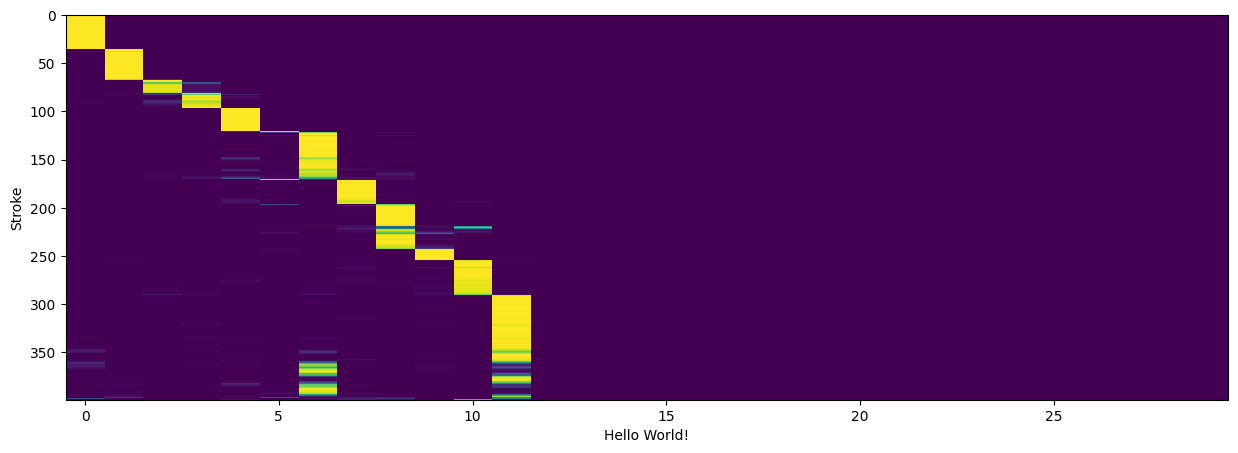

In [144]:
# Plotting the attention weights. In the transformer case we should see good alignment between some of the
# heads in the cross-attention block
attention_heads = jnp.squeeze(attn_w['decoder_layer2_block2'], 0)

plt.figure(num=None, figsize=(15, 5))

plt.imshow(attention_heads[1], origin='upper', interpolation='nearest', aspect='auto')

plt.ylabel('Stroke')
plt.xlabel(encoding_sent)

In [ ]:
jnp.sum(attention_heads, 0).shape

(400, 30)

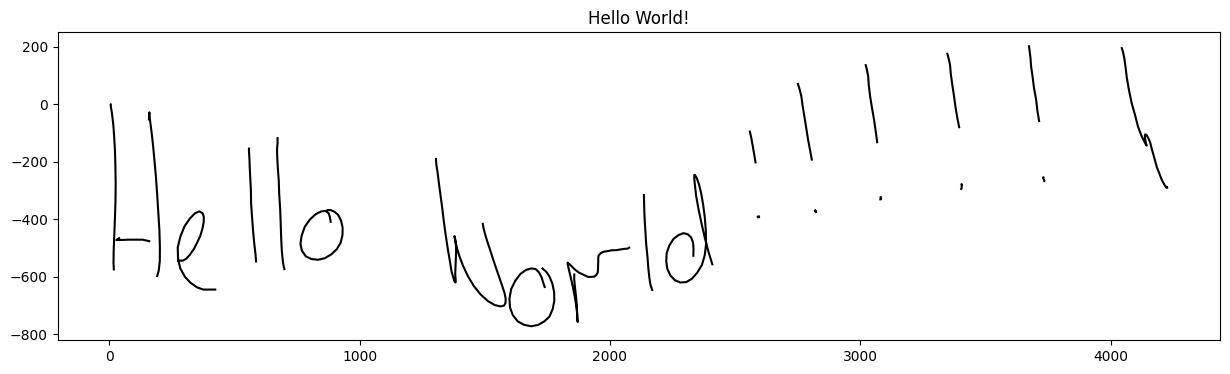

In [145]:
plot_stroke(predicted[0, :, :], one_hot_sentence[0, :])

In [ ]:
encoding_sent = 'Hello World from Graves\' RNN'

one_hot_sentence = convert_sentence(encoding_sent)

predicted, attn_w = fast_stroke_predict.apply(params, rng, one_hot_sentence, 500, 1.5, 2)

TypeError: PRNG key seed must be an integer; got DeviceArray(20., dtype=float32, weak_type=True)

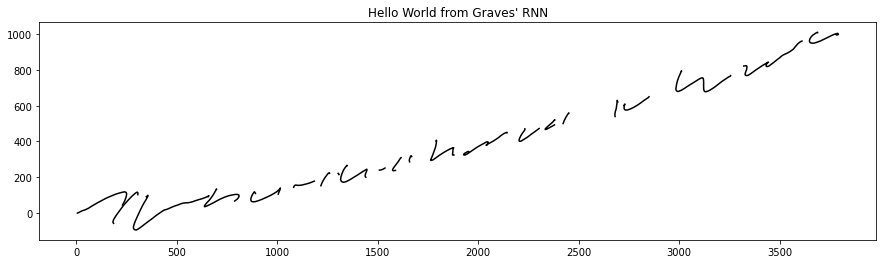

In [ ]:
plot_stroke(predicted[0, :, :], one_hot_sentence[0, :])

In [ ]:
def plot_sample(rng):
    #rng = jax.random.PRNGKey(54) 

    result = jnp.ones((1, MAX_LEN, 3))*-1

    result = result.at[0, 0, :].set(0)

    result, rng = jax.lax.fori_loop(0, MAX_LEN-1, evaluate, (result, rng))

    plot_stroke(result[0, :, :], one_hot_sentence[0, :])

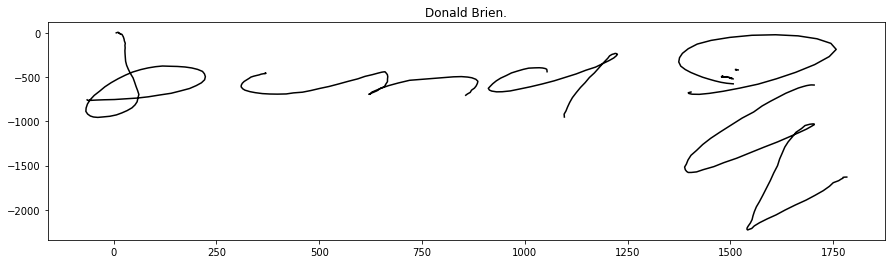

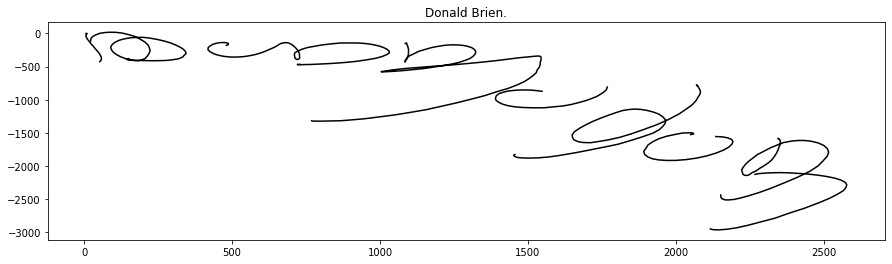

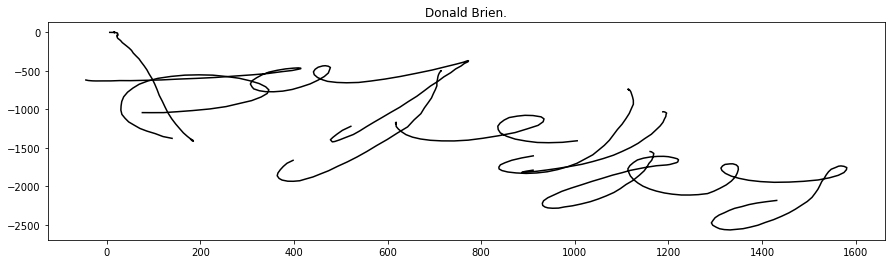

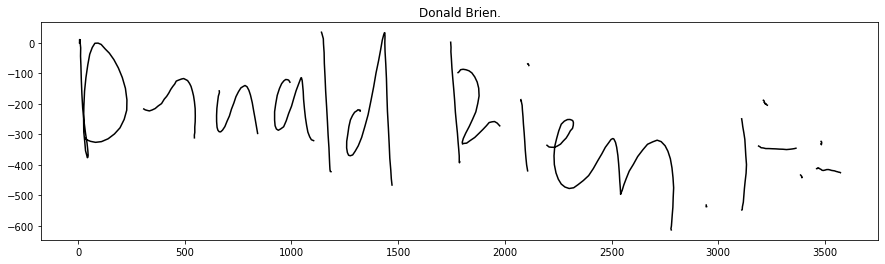

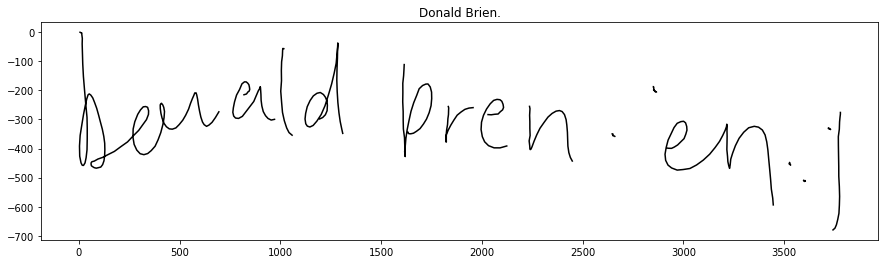

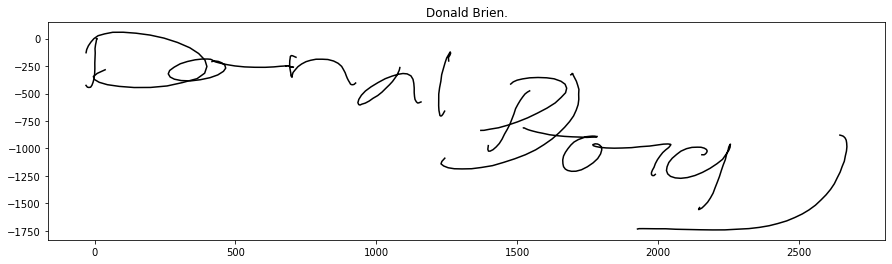

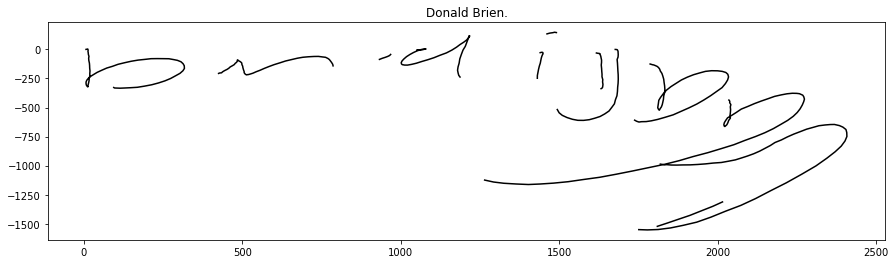

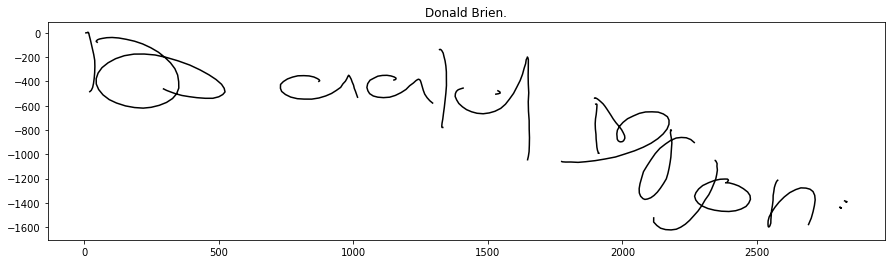

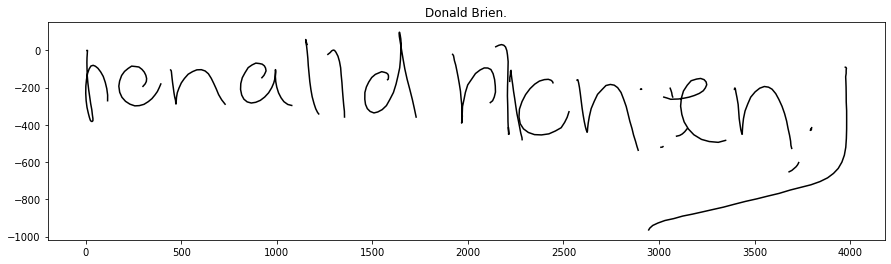

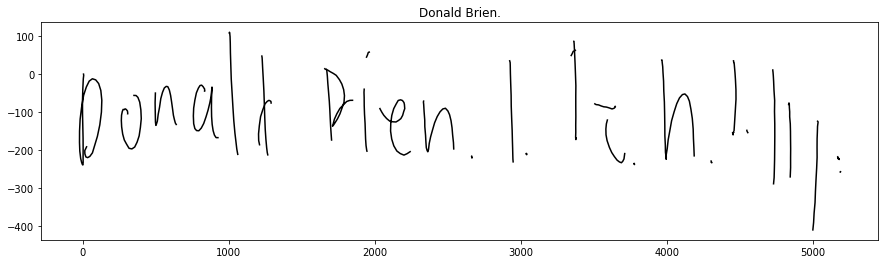

In [ ]:
seq = hk.PRNGSequence(12)

for i in range(10):
    plot_sample(next(seq))

In [ ]:
results = evaluate(one_hot_sentence)

TypeError: evaluate() missing 1 required positional argument: 'carry'

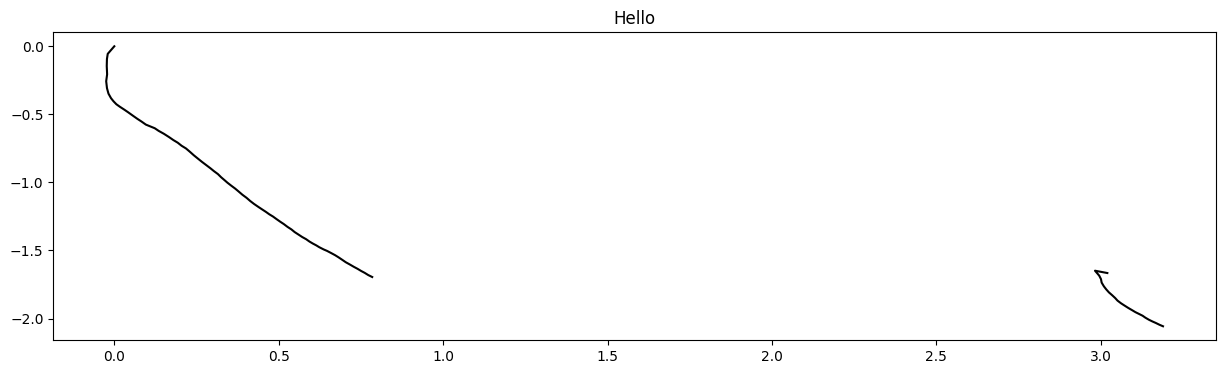

In [ ]:
plot_stroke(result[0, :, :], one_hot_sentence[0, :])

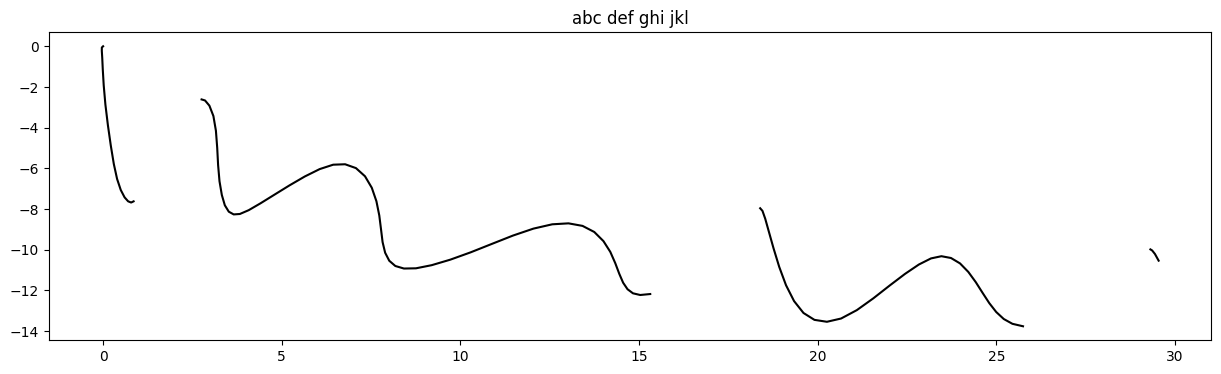

In [ ]:
plot_stroke(results[0, :, :], one_hot_sentence[0, :])

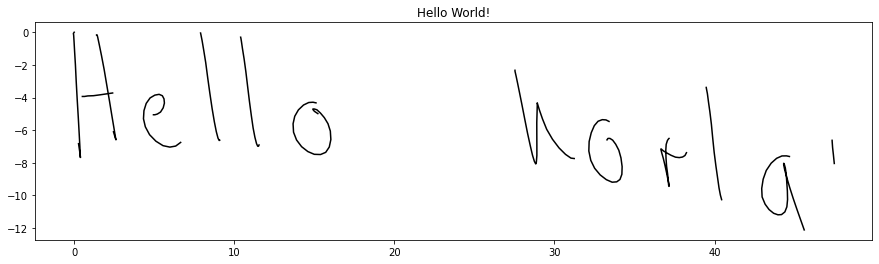

In [ ]:
plot_stroke(results[0, :, :], one_hot_sentence[0, :])

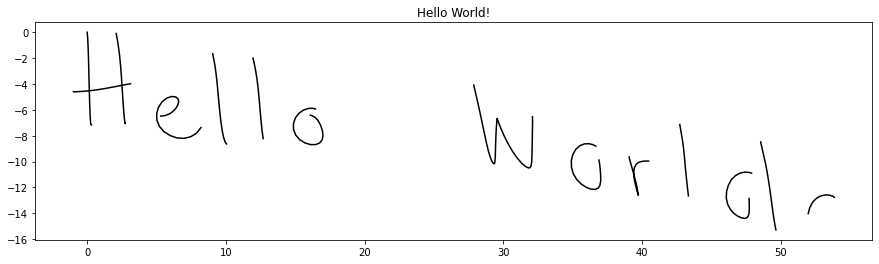

In [ ]:
plot_stroke(results[0, :, :], one_hot_sentence[0, :])

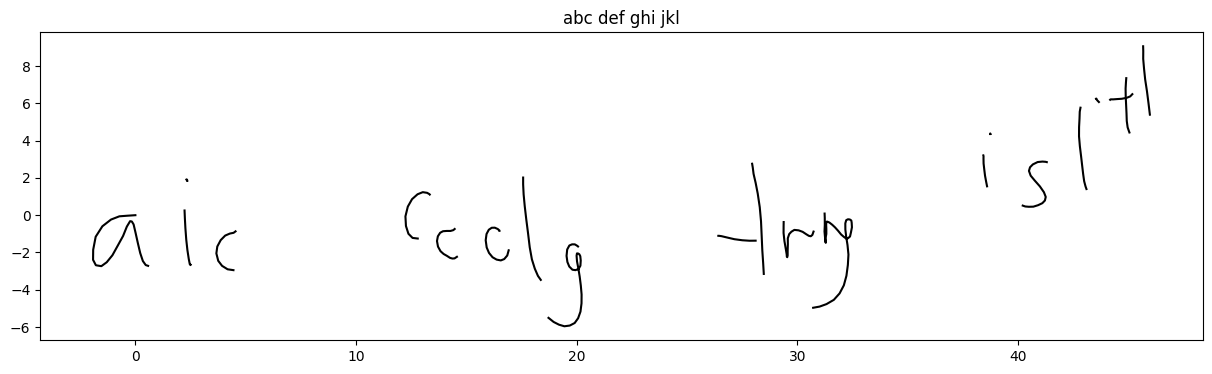

In [ ]:
plot_stroke(results[0, :, :], one_hot_sentence[0, :])